In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('Data/elec_merge_20160101_20190930.csv')
df.shape
# 20160101~20161231 [0~366]
# 20170101~20171231 [366~731]
# 20180101~20181231 [731~1095]
# 20190101~20190930 [1096~1368]

(1461, 10)

In [5]:
df.head()

,日期,尖峰負載(MW),淨尖峰供電能力(MW),備轉容量(MW),備轉容量率(%),工業用電(百萬度),民生用電(百萬度),isHoliday,isHoliday(Next7),Week
0,2016-01-01,23038.0,25366.0,2328.0,10.11,263.799,189.300,1.0,0.0,4.0
1,2016-01-02,23209.0,25179.0,1970.0,8.49,261.975,187.991,1.0,1.0,5.0
2,2016-01-03,23686.0,26219.0,2533.0,10.69,266.167,190.999,1.0,1.0,6.0
3,2016-01-04,27518.0,29528.0,2010.0,7.31,302.227,216.875,0.0,0.0,0.0
4,2016-01-05,27635.0,29735.0,2100.0,7.60,313.328,224.841,0.0,0.0,1.0


In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
def rmse(y_pred, y_true):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

## 查看資料狀態

In [8]:
def plot_year(dates, value, title=None): 
    '''
    Args:
        dates: the 'date' column of the data
        value: the value you want to draw
        title: figure title
    Return:
        a plot
    '''
    plt.figure(figsize=(20,4))
    x_axis = pd.to_datetime(dates, format='%Y-%m-%d')
    plt.plot_date(x_axis, value, '-')
    plt.title(title)

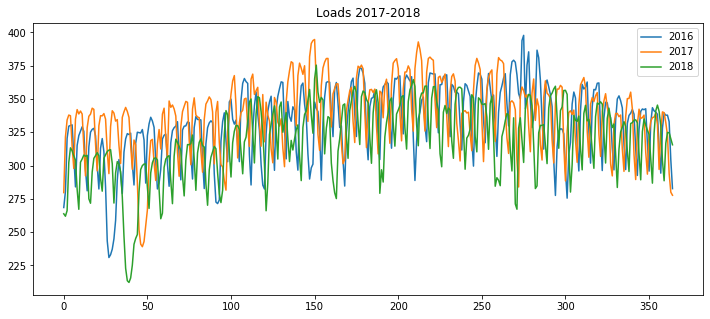

In [20]:
plt.figure(figsize=(12,5))
x_axis = range(0, 365)
plt.plot(x_axis, df[366:731].head(365)['工業用電(百萬度)'], '-')
plt.plot(x_axis, df[731:1096].head(365)['工業用電(百萬度)'], '-')
plt.plot(x_axis, df[:366].head(365)['工業用電(百萬度)'], '-')

# plt.plot(x_axis, df[1096:].head(365)['工業用電(百萬度)'], '-')
plt.title('Loads 2017-2018')
plt.legend(['2016', '2017', '2018'])
plt.show()

## 欄位篩選
- 使用 2016年1月至2018年12月的資料進行訓練
- 使用 2019年1月至2019年9月的資料進行測試
- 此實驗僅保留用電量欄位

In [155]:
RawTrain = df[:1096]
# RawTrain = df[366:1096]
RawTest = df[1096:]

In [179]:
features_select = ["工業用電(百萬度)", "isHoliday", "尖峰負載(MW)"]
# features_select = ["工業用電(百萬度)"]

In [180]:
# 訓練資料擷取
training_set = pd.DataFrame(RawTrain[features_select])
training_set.shape

(1096, 3)

## 資料前處理

In [181]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

C:\Users\siang\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## 訓練資料

In [182]:
# 自定義變數
Timesteps = 30
OutputDay = 1

In [183]:
X_train, y_train = [], []

for i in range(Timesteps, len(training_set)):  # 1258 是訓練集總數
    X_train.append(training_set_scaled[i-Timesteps:i])
    y_train.append(training_set_scaled[i:i+OutputDay, 0]) # 0 = 工業用電(百萬度)
    
# 轉成numpy array的格式，以利輸入 RNN    
X_train, y_train = np.array(X_train), np.array(y_train)  
print(X_train.shape)
print(y_train.shape)

# Reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
print(X_train.shape)

(1066, 30, 3)
(1066, 1)
(1066, 30, 3)


## Model

In [184]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, CuDNNLSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.optimizers import RMSprop

### CuDNNLSTM

In [185]:
# Initialising the CuDNNLSTM
model = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
model.add(CuDNNLSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

for i in range(2):
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(CuDNNLSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(CuDNNLSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_29 (CuDNNLSTM)    (None, 30, 50)            11000     
_________________________________________________________________
dropout_29 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
cu_dnnlstm_30 (CuDNNLSTM)    (None, 30, 50)            20400     
_________________________________________________________________
dropout_30 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
cu_dnnlstm_31 (CuDNNLSTM)    (None, 30, 50)            20400     
_________________________________________________________________
dropout_31 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
cu_dnnlstm_32 (CuDNNLSTM)    (None, 50)                20400     
__________

### LSTM

In [186]:
# # Initialising the LSTM
# model = Sequential()
# # Adding the first LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# model.add(Dropout(0.2))

# for i in range(2):
#     # Adding a second LSTM layer and some Dropout regularisation
#     model.add(LSTM(units = 50, return_sequences = True))
#     model.add(Dropout(0.2))

# # Adding a fourth LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50))
# model.add(Dropout(0.2))

# # Adding the output layer
# model.add(Dense(units = 1))

# model.summary()

In [187]:
batch_size = 16
epochs = 100

# initialize optimizer
# optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=0.0001), metrics=['mape'])
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train,
          batch_size = batch_size,
          epochs = epochs,
          verbose=1,
          validation_split=0.1)

Train on 959 samples, validate on 107 samples
Epoch 1/100
959/959 [==============================] - 2s 2ms/step - loss: 0.0438 - val_loss: 0.0145
Epoch 2/100
959/959 [==============================] - 1s 941us/step - loss: 0.0228 - val_loss: 0.0191
Epoch 3/100
959/959 [==============================] - 1s 962us/step - loss: 0.0229 - val_loss: 0.0157
Epoch 4/100
959/959 [==============================] - 1s 946us/step - loss: 0.0227 - val_loss: 0.0140
Epoch 5/100
959/959 [==============================] - 1s 938us/step - loss: 0.0222 - val_loss: 0.0136
Epoch 6/100
959/959 [==============================] - 1s 938us/step - loss: 0.0229 - val_loss: 0.0131
Epoch 7/100
959/959 [==============================] - 1s 923us/step - loss: 0.0216 - val_loss: 0.0158
Epoch 8/100
959/959 [==============================] - 1s 923us/step - loss: 0.0203 - val_loss: 0.0182
Epoch 9/100
959/959 [==============================] - 1s 929us/step - loss: 0.0212 - val_loss: 0.0114
Epoch 10/100
959/959 [=======

---
# Time

In [188]:
t = 1

---
## Load Model

In [189]:
# # load
# from keras.models import load_model
# model = load_model('Model/industryElec_RNN(30to1)_model_0' + str(t) + '.h5')

---
## Self-Prediction

In [190]:
self_true = pd.DataFrame(training_set[["工業用電(百萬度)"]]).values[Timesteps:,]
self_predict = model.predict(X_train)
# self_prediction = sc.inverse_transform(self_predict)
self_prediction = self_predict * (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]

In [191]:
# RMSE
print("RMSE: ", rmse(self_true, self_prediction))
# MAPE
print("MAPE: ", mean_absolute_percentage_error(self_true, self_prediction))

RMSE:  9.536787089610712
MAPE:  2.0589806578030325


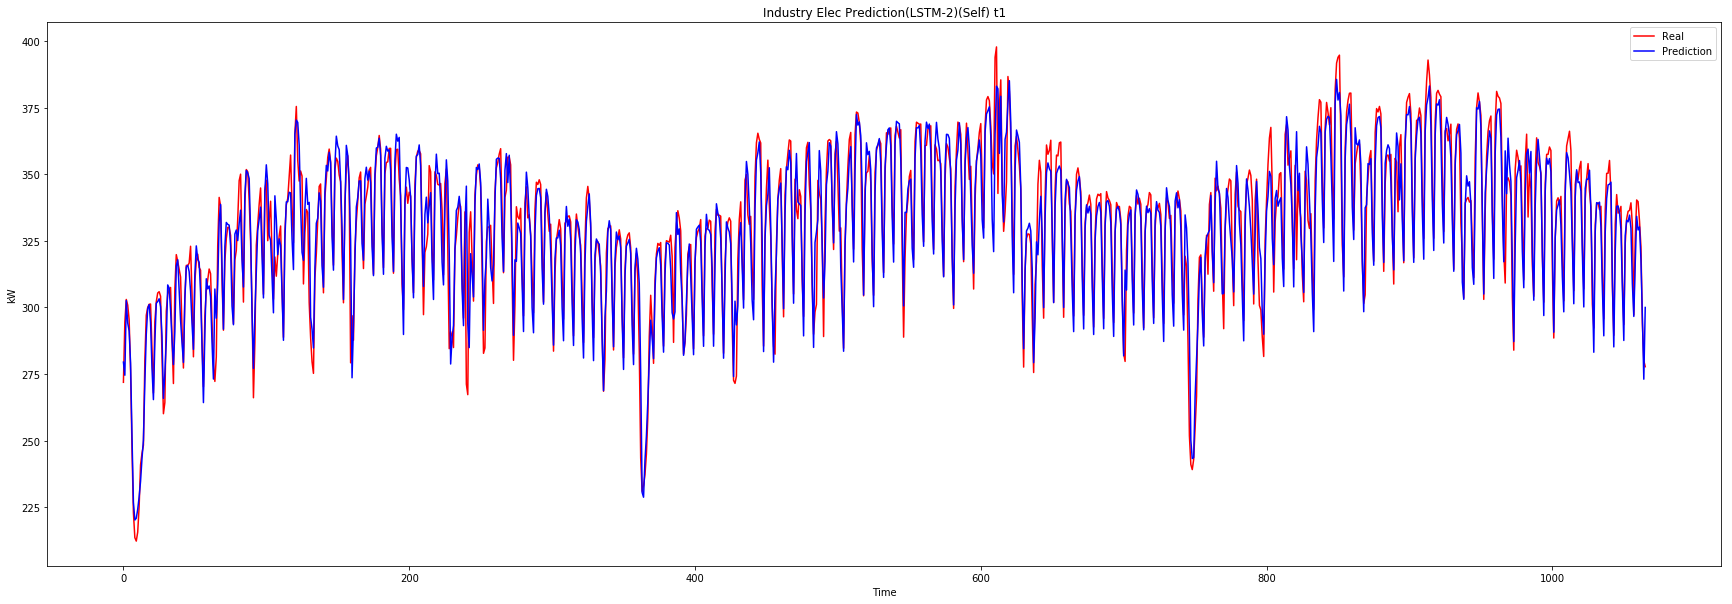

In [192]:
# Visualising the model
plt.figure(figsize=(30, 10))
plt.plot(self_true, color = 'red', label = 'Real')
plt.plot(self_prediction, color = 'blue', label = 'Prediction')
plt.title('Industry Elec Prediction(LSTM-2)(Self) t' + str(t))
plt.xlabel('Time')
plt.ylabel('kW')
plt.legend()
plt.show()

---
## Test-Prediction

In [193]:
# 自定義變數
# Pre_step = 1
# Pre_step = 4
Pre_step = 39

In [194]:
# 真實值擷取
pre_time = 7 * Pre_step
test_set = pd.DataFrame(RawTest[["工業用電(百萬度)"]])
test_set = test_set[:pre_time]
# 真實資料
real_elec = test_set.values

In [196]:
dataset_total = pd.DataFrame(df[features_select])
dataset_total = dataset_total[:len(training_set) + pre_time]

inputs = dataset_total[len(dataset_total) - len(test_set) - 30:].values
inputs = inputs.reshape(-1, dataset_total.shape[1])
 # Feature Scaling
inputs = sc.transform(inputs)

In [197]:
X_test = []
for i in range(30, 30 + pre_time):  
    # timesteps 30；60 = 先前的 30天資料 + 2019年的 30天資料
    X_test.append(inputs[i-30:i])
X_test = np.array(X_test)
# Reshape 成 3-dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2])) 

In [198]:
# 執行預測
predicted_elec = model.predict(X_test)
# 尺度還原
predicted_elec = predicted_elec * (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]

## 計算評估指標

In [199]:
# RMSE
print("RMSE: ", rmse(real_elec, predicted_elec))
# MAPE
print("MAPE: ", mean_absolute_percentage_error(real_elec, predicted_elec))

RMSE:  11.793756415281786
MAPE:  2.6367626867050324


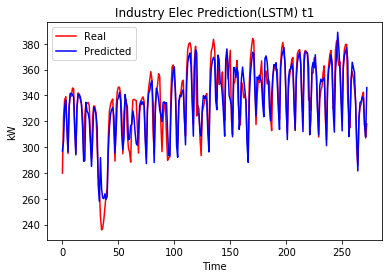

In [200]:
# Visualising the results
plt.plot(real_elec, color = 'red', label = 'Real')
plt.plot(predicted_elec, color = 'blue', label = 'Predicted')
plt.title('Industry Elec Prediction(LSTM) t' + str(t))
plt.xlabel('Time')
plt.ylabel('kW')
plt.legend()
plt.show()

## Save Model

In [201]:
# import h5py
# Model.save('Model/industryElec_LSTM(30to1)_model_0' + str(t) + '.h5')